# Basic circuits on IBM hardware with qiskit

## Bell state $\ket{\Phi^-}$ and it's measurement

$\ket{\Phi^-} = \frac{1}{\sqrt{2}} ( \ket{00} - \ket{11} ) $

One way to prepare:

$\ket{\Phi^-} = \text{CNOT} H_1 X_1 \ket{00} = \text{CNOT}(H \otimes I)(X \otimes I)(\ket0 \otimes \ket0)= \frac{1}{\sqrt{2}} ( \ket{00} - \ket{11} ) $

Another way to prepare:

$\ket{\Phi^-} =  Z_1 \text{CNOT} H_1 \ket{00} = (Z \otimes I) \text{CNOT}(H \otimes I)(\ket0 \otimes \ket0) = \frac{1}{\sqrt{2}} ( \ket{00} - \ket{11})$

## Part 1: Measure on hardware

### Step 1: Map problem to the circuit and operators

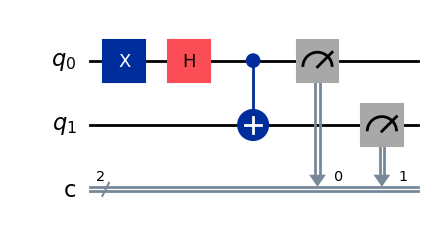

In [1]:
from qiskit import QuantumCircuit

# First way
qc1 = QuantumCircuit(2, 2)
qc1.x(0)
qc1.h(0)
qc1.cx(0, 1)
qc1.measure([0, 1], [0, 1])
qc1.draw(output='mpl')

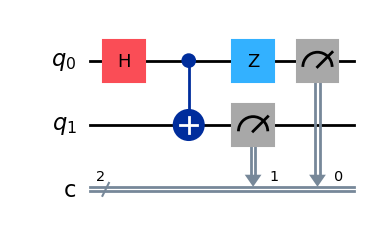

In [2]:
# Another way
qc2 = QuantumCircuit(2, 2)
qc2.h(0)
qc2.cx(0, 1)
qc2.z(0)
qc2.measure([0, 1], [0, 1])
qc2.draw(output='mpl')

In [3]:
# Observable for first circuit
from qiskit.quantum_info import Pauli

observable = Pauli('ZZ')

### Step 2: Optimize circuit observables

In [4]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting backend")

qc_list = [qc1, qc2]
transpiled_qcs = transpile(qc_list, backend=backend, optimization_level=1)
observable = observable.apply_layout(transpiled_qcs[0].layout)

Done getting backend


### Step 3: Execute on hardware

Sampler for 2 circuits and Estimator only for the first circuit

Sampler - basic. Estimator - for various observables and variational circuits.

In [5]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job1 = sampler.run(transpiled_qcs)
print(f"Job submitted: {job1.job_id()}")

# Sampler just does a bunch of measurements on computational (Z) basis


Job submitted: d03hxtzkzhn0008e3vng


In [6]:

from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"

job2 = estimator.run([(transpiled_qcs[0], observable)])
print(f"Job submitted: {job2.job_id()}")

# Estimator evaluates expval of a certain given observable. Can also have qc that is parameterized and be given an angle list, for which for each angle it would measure the expval

Job submitted: d03hxz7nhqag008vkck0


### Step 4: Post process

In [7]:
import matplotlib.pyplot as plt

job1 = service.job(job1.job_id())
job2 = service.job(job2.job_id())

result1 = job1.result()
result2 = job2.result()

In [8]:
print(result1[0].data.c.get_counts())
print(result1[1].data.c.get_counts())
print(result2[0].data.evs)

{'01': 135, '00': 1936, '11': 1867, '10': 158}
{'01': 148, '00': 1888, '11': 1931, '10': 129}
0.9630888450819115


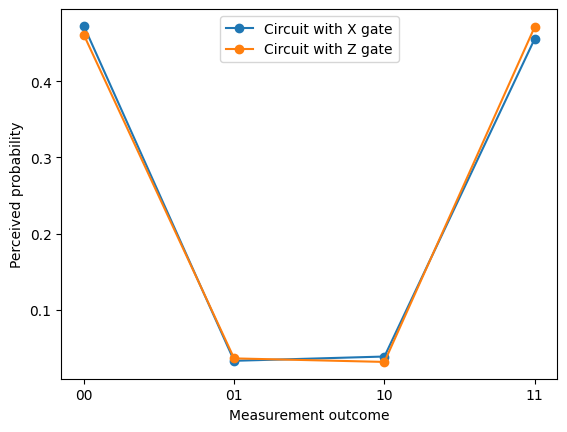

In [9]:
counts1 = result1[0].data.c.get_counts()
counts2 = result1[1].data.c.get_counts()
num_shots1 = result1[0].data.c.num_shots
num_shots2 = result1[1].data.c.num_shots

plt.plot(["00", "01", "10", "11"], [counts1.get(outcome, 0) / num_shots1 for outcome in ["00", "01", "10", "11"]], label="Circuit with X gate", marker='o')
plt.plot(["00", "01", "10", "11"], [counts2.get(outcome, 0) / num_shots2 for outcome in ["00", "01", "10", "11"]], label="Circuit with Z gate", marker='o')
plt.xlabel("Measurement outcome")
plt.ylabel("Perceived probability")
plt.legend()

## Part 2: Measurement on simulator

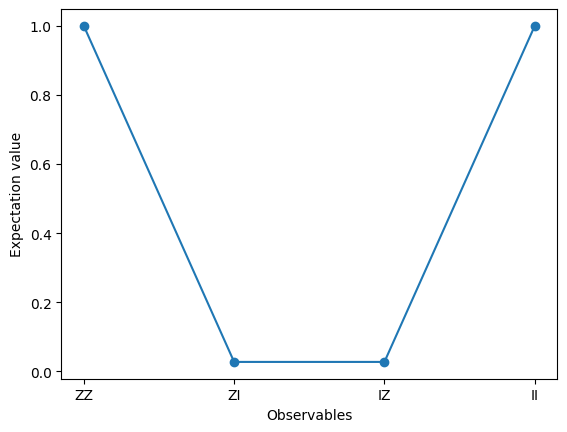

In [23]:
from qiskit_aer.primitives import Estimator as EstimatorSim

observables = [Pauli('ZZ'), Pauli('ZI'), Pauli('IZ'), Pauli('II')]

estimator_sim = EstimatorSim()
job = estimator_sim.run([qc1] * len(observables), observables)

data = ['ZZ', 'ZI', 'IZ', 'II']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

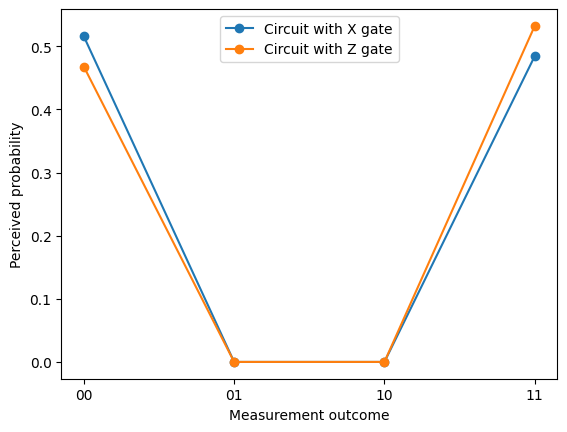

In [29]:
from qiskit_aer.primitives import Sampler as SamplerSim

sampler_sim = SamplerSim()
job = sampler_sim.run([qc1, qc2])

result = job.result()
counts_sim1 = result.quasi_dists[0].binary_probabilities()
counts_sim2 = result.quasi_dists[1].binary_probabilities()

plt.plot(["00", "01", "10", "11"], [counts_sim1.get(outcome, 0) for outcome in ["00", "01", "10", "11"]], label="Circuit with X gate", marker='o')
plt.plot(["00", "01", "10", "11"], [counts_sim2.get(outcome, 0) for outcome in ["00", "01", "10", "11"]], label="Circuit with Z gate", marker='o')
plt.xlabel("Measurement outcome")
plt.ylabel("Perceived probability")
plt.legend()